# Import Library

In [2]:
# Basic Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# GUI (for later)
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Load and Merge Data

In [4]:
# Define paths 
files = {
    "Urban_Dongsi": "PRSA_Data_Dongsi_20130301-20170228.csv",
    "Suburban_Changping": "PRSA_Data_Changping_20130301-20170228.csv",
    "Rural_Huairou": "PRSA_Data_Huairou_20130301-20170228.csv",
    "Industrial_Aotizhongxin": "PRSA_Data_Aotizhongxin_20130301-20170228.csv"
}

# Load datasets
dfs = {}
for key, path in files.items():
    df = pd.read_csv(path)
    df["station_type"] = key  
    dfs[key] = df

# Merge into one DataFrame
df_all = pd.concat(dfs.values(), ignore_index=True)

# Exploratory Data Analysis (EDA)

## a) Data Overview

In [7]:
# Shape and data types
print(df_all.shape)
print(df_all.dtypes)

# Summary statistics
print(df_all.describe(include='all'))

# Check missing values
missing_values = df_all.isnull().sum()
print("Missing Values:\n", missing_values)

(140256, 19)
No                int64
year              int64
month             int64
day               int64
hour              int64
PM2.5           float64
PM10            float64
SO2             float64
NO2             float64
CO              float64
O3              float64
TEMP            float64
PRES            float64
DEWP            float64
RAIN            float64
wd               object
WSPM            float64
station          object
station_type     object
dtype: object
                No           year          month            day  \
count   140256.000  140256.000000  140256.000000  140256.000000   
unique         NaN            NaN            NaN            NaN   
top            NaN            NaN            NaN            NaN   
freq           NaN            NaN            NaN            NaN   
mean     17532.500    2014.662560       6.522930      15.729637   
std      10122.141       1.177201       3.448715       8.800123   
min          1.000    2013.000000       1.000000

## b) Preprocessing

In [9]:
# Drop duplicates
df_all.drop_duplicates(inplace=True)

# Handle missing values (e.g., fill with mean or drop)
df_all.fillna(df_all.mean(numeric_only=True), inplace=True)

# Convert date/time to datetime format
df_all['datetime'] = pd.to_datetime(df_all[['year', 'month', 'day', 'hour']])

# Reorder columns
cols = ['datetime'] + [col for col in df_all.columns if col != 'datetime']
df_all = df_all[cols]

## c) Visualization

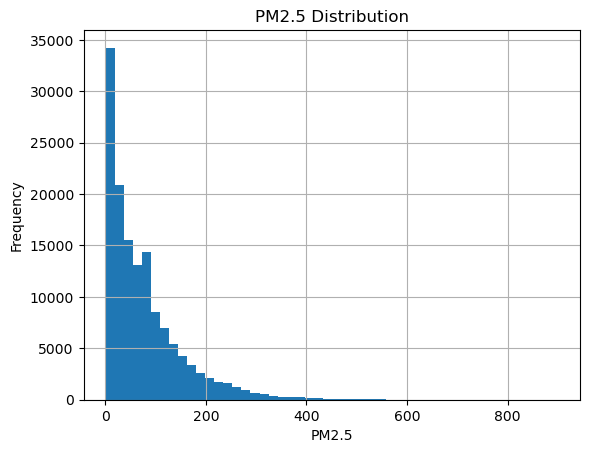

In [11]:
# Univariate
df_all['PM2.5'].hist(bins=50)
plt.title('PM2.5 Distribution')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()

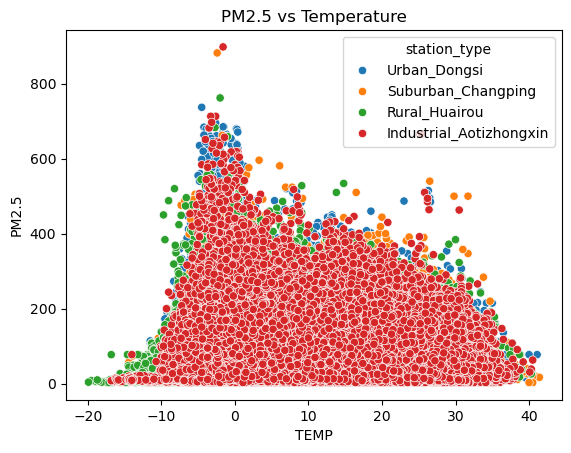

In [12]:
# Bivariate - PM2.5 vs Temperature
sns.scatterplot(data=df_all, x='TEMP', y='PM2.5', hue='station_type')
plt.title('PM2.5 vs Temperature')
plt.show()

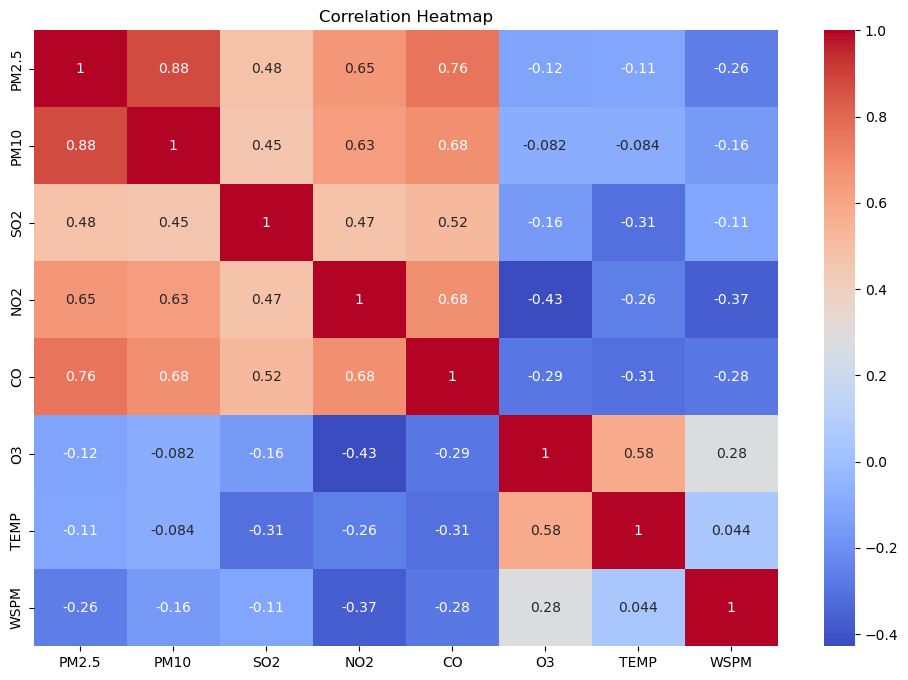

In [13]:
# Heatmap of correlations
plt.figure(figsize=(12, 8))
corr = df_all[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'WSPM']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Model Building: Random Forest

In [15]:
# Features and Target
features = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']
X = df_all[features]
y = df_all['PM2.5']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 408.0009499042282
R² Score: 0.9306902677789192


# GUI with Tkinter (Multi-page App)

In [ ]:
class AirQualityApp(tk.Tk):
    def __init__(self, dataset, y_test, y_pred):
        super().__init__()
        self.title("Air Quality Analysis App")
        self.geometry("1000x700")
        self.dataset = dataset
        self.y_test = y_test
        self.y_pred = y_pred

        # Tabs
        tab_control = ttk.Notebook(self)
        self.tab1 = ttk.Frame(tab_control)
        self.tab2 = ttk.Frame(tab_control)
        self.tab3 = ttk.Frame(tab_control)

        tab_control.add(self.tab1, text='Data Overview')
        tab_control.add(self.tab2, text='EDA')
        tab_control.add(self.tab3, text='Model & Prediction')
        tab_control.pack(expand=1, fill='both')

        self.create_data_overview()
        self.create_eda()
        self.create_modeling()

    def create_data_overview(self):
        # Display dataset summary
        text = tk.Text(self.tab1, wrap='none')
        text.insert(tk.END, str(self.dataset.describe()))
        text.pack(expand=True, fill='both')

    def create_eda(self):
        # Create a frame to hold multiple plots
        frame = tk.Frame(self.tab2)
        frame.pack(expand=True, fill='both')

        # PM2.5 Distribution Histogram
        fig1, ax1 = plt.subplots(figsize=(6, 4))
        self.dataset['PM2.5'].hist(bins=50, ax=ax1)
        ax1.set_title('PM2.5 Distribution')
        ax1.set_xlabel('PM2.5')
        ax1.set_ylabel('Frequency')
        canvas1 = FigureCanvasTkAgg(fig1, master=frame)
        canvas1.draw()
        canvas1.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Scatterplot: PM2.5 vs TEMP
        fig2, ax2 = plt.subplots(figsize=(6, 4))
        sns.scatterplot(data=self.dataset, x='TEMP', y='PM2.5', hue='station_type', ax=ax2)
        ax2.set_title('PM2.5 vs Temperature')
        canvas2 = FigureCanvasTkAgg(fig2, master=frame)
        canvas2.draw()
        canvas2.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Heatmap
        fig3, ax3 = plt.subplots(figsize=(8, 6))
        corr = self.dataset[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'WSPM']].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax3)
        ax3.set_title("Correlation Heatmap")
        canvas3 = FigureCanvasTkAgg(fig3, master=frame)
        canvas3.draw()
        canvas3.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)

    def create_modeling(self):
        frame = tk.Frame(self.tab3)
        frame.pack(expand=True, fill='both')

        # Metrics
        r2 = r2_score(self.y_test, self.y_pred)
        mse = mean_squared_error(self.y_test, self.y_pred)
        label = tk.Label(frame, text=f"Model Evaluation:\nR² Score: {r2:.3f}\nMSE: {mse:.2f}", font=('Arial', 12))
        label.pack(pady=10)

        # Scatterplot: True vs Predicted
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(self.y_test, self.y_pred, alpha=0.3, color='green')
        ax.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'r--')
        ax.set_title("True vs Predicted PM2.5")
        ax.set_xlabel("Actual PM2.5")
        ax.set_ylabel("Predicted PM2.5")

        canvas = FigureCanvasTkAgg(fig, master=frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

# Run the app
app = AirQualityApp(df_all, y_test, y_pred)
app.mainloop()